# Импорты библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime

# Чтение данных

In [2]:
df_path = "marketplace.csv"

df = pd.read_csv(df_path)
display(df.head())
df.info()

,user_id,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
0,user_000000,12,2025-03-22,2024-08-17,browser_00,2025-03-22,0.0,85.329559,0.0
1,user_000001,1,2025-05-05,2025-05-15,browser_01,2025-05-20,0.0,21.819124,0.0
2,user_000002,5,2025-01-19,2025-01-23,browser_02,2025-02-20,0.3,194.612980,485.0
3,user_000003,3,2025-03-15,2023-09-05,browser_02,NaN,0.0,138.780814,0.0
4,user_000004,1,2025-05-05,2025-05-14,browser_00,2025-05-11,0.0,16.334507,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25335 entries, 0 to 25334
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       25335 non-null  object 
 1   platform_num  25335 non-null  int64  
 2   first_login   25335 non-null  object 
 3   reg_dt        25331 non-null  object 
 4   browser       25335 non-null  object 
 5   first_buy     24361 non-null  object 
 6   target        25335 non-null  float64
 7   total_buy     25335 non-null  float64
 8   total_return  25335 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


# Чистка данных

## Преобразование типов

In [3]:
df_cleaned = df.copy()

# df_cleaned = df_cleaned.astype({'reg_dt': int, 'first_buy': int, 'first_login': dt})

df_cleaned["reg_dt"] = pd.to_datetime(df_cleaned["reg_dt"], errors="coerce")
df_cleaned["first_buy"] = pd.to_datetime(df_cleaned["first_buy"], errors="coerce")
df_cleaned["first_login"] = pd.to_datetime(df_cleaned["first_login"], errors="coerce")

df_cleaned["user_id"] = df_cleaned["user_id"].apply(lambda x: int(x.strip("user_")))
df_cleaned["browser"] = df_cleaned["browser"].apply(lambda x: int(x.strip("browser_")))

## Заполнение нулей

In [4]:
df_cleaned["first_buy"].fillna(df_cleaned[['first_login', 'reg_dt']].max(axis=1), inplace=True)

## Склеивание дублей и индексация по user_id

In [5]:
df_cleaned = df_cleaned.groupby(by="user_id").agg(
    {
        "platform_num": "min",
        "first_login": "min",
        "reg_dt": "min",
        "browser": "min",
        "first_buy": "min",
        "target": "mean",
        "total_buy": "sum",
        "total_return": "sum",
    }
)
df_cleaned.head()

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0
2,5,2025-01-19,2025-01-23,2,2025-02-20,0.3,194.612980,485.0
3,3,2025-03-15,2023-09-05,2,2025-03-15,0.0,138.780814,0.0
4,1,2025-05-05,2025-05-14,0,2025-05-11,0.0,16.334507,0.0


### Вспомогательные методы

In [6]:
def shapiro_check(dataset, col, alpha=0.05, n=3000):
    """
    Шапиро. Тест, является ли распределение СВ нормальным
    """
    checked_dataset = dataset[col] if n is None else dataset[col].sample(n=n)
    stat, pvalue = st.shapiro(checked_dataset)
    print('Шапиро')
    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def kstest_check(dataset, col, alpha=0.05):
    """
    Колмогоров-Смирнов. Тест, является ли распределение СВ нормальным
    """
    arr = dataset[col]
    mu = arr.mean()
    sigma = arr.std(ddof=1)
    stat, pvalue = st.kstest(arr, 'norm', args=(mu, sigma))

    print('Колмогоров-Смирнов')

    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def iqr_filter(dataset, col):
    """
    Фильтр по межквартильному размаху
    """
    medi = dataset[col].median()
    Q1, Q3 = dataset[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1

    bottom, top = medi - 1.5 * IQR, medi + 1.5 * IQR

    return dataset[(dataset[col] >= bottom) & (dataset[col] <= top)]

## Устраняем асинхронность в датах - дата первой покупки не должна быть меньше даты логина или регистрации

In [7]:
df_cleaned.loc[(df_cleaned['reg_dt'] > df_cleaned['first_buy']), ['reg_dt']] = df_cleaned['first_buy']
df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy']), ['first_login']] = df_cleaned['first_buy']

## Убрать выбросы по межквартильному размаху

In [8]:
df_cleaned_iqr = pd.DataFrame(data=df_cleaned)
df_cleaned_iqr = iqr_filter(df_cleaned_iqr, 'total_buy')

shapiro_check(df_cleaned_iqr, 'total_buy')
kstest_check(df_cleaned_iqr, 'total_buy')
shapiro_check(df_cleaned_iqr, 'total_return')
kstest_check(df_cleaned_iqr, 'total_return')

Шапиро
Данные total_buy скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_buy скорее всего распределены не нормально

Шапиро
Данные total_return скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_return скорее всего распределены не нормально



## Убрать выбросы по zscore

In [9]:
df_zcore_filtered = pd.DataFrame(data=df_cleaned)

df_zcore_filtered = df_zcore_filtered[
    (abs(st.zscore(df_cleaned["total_buy"])) < 3)
    & (abs(st.zscore(df_cleaned["total_return"])) < 3)
]

shapiro_check(df_zcore_filtered, 'total_buy')
kstest_check(df_zcore_filtered, 'total_buy')
shapiro_check(df_zcore_filtered, 'total_return')
kstest_check(df_zcore_filtered, 'total_return')

Шапиро
Данные total_buy скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_buy скорее всего распределены не нормально

Шапиро
Данные total_return скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_return скорее всего распределены не нормально



## Убрать выбросы по 99-ому процентилю

In [10]:
q99 = df_cleaned["total_buy"].quantile(0.99)
df_q99_filtered = df_cleaned[df_cleaned["total_buy"] < q99]
df_q99_filtered = df_q99_filtered.drop([383]) # ручная чистка выброса, не отсечённого процентилем


In [11]:
print('С фильтром по межквартильному размаху')
display(df_cleaned_iqr.describe())
print('С фильтром по z-score')
display(df_zcore_filtered.describe())
print('С фильтром по 99-ому процентилю')
display(df_q99_filtered.describe())

С фильтром по межквартильному размаху


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
count,20439.000000,20439,20439,20439.000000,20439,20439.000000,20439.000000,20439.000000
mean,4.730760,2025-03-10 23:36:57.701453312,2025-01-05 03:51:34.848084480,3.380841,2025-03-19 19:45:14.398943232,0.002579,63.771364,20.453601
min,1.000000,2023-08-12 00:00:00,2022-10-11 00:00:00,0.000000,2023-08-12 00:00:00,-3.428557,0.000000,0.000000
25%,1.000000,2025-02-07 00:00:00,2024-12-04 00:00:00,2.000000,2025-02-16 00:00:00,0.000000,15.801008,0.000000
50%,3.000000,2025-03-21 00:00:00,2025-02-27 00:00:00,2.000000,2025-03-27 00:00:00,0.000000,34.464635,0.000000
75%,5.000000,2025-04-26 00:00:00,2025-04-22 00:00:00,3.000000,2025-05-07 00:00:00,0.000000,86.964551,0.000000
max,194.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,30.000000,2025-07-26 00:00:00,0.300000,329.032877,30602.033000
std,7.341859,NaN,NaN,3.593518,NaN,0.207371,71.620197,242.549226


С фильтром по z-score


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
count,25094.000000,25094,25094,25094.000000,25094,25094.000000,25094.000000,25094.000000
mean,6.176616,2025-03-05 12:32:45.983900416,2024-12-07 00:34:05.174145536,3.389615,2025-03-13 23:55:10.783454208,0.002129,472.302838,152.663463
min,1.000000,2023-08-08 00:00:00,2022-10-11 00:00:00,0.000000,2023-08-08 00:00:00,-3.428557,0.000000,0.000000
25%,2.000000,2025-02-03 00:00:00,2024-10-16 00:00:00,2.000000,2025-02-13 00:00:00,0.000000,19.184550,0.000000
50%,3.000000,2025-03-20 00:00:00,2025-02-16 00:00:00,2.000000,2025-03-26 00:00:00,0.000000,51.995138,0.000000
75%,6.000000,2025-04-21 00:00:00,2025-04-16 00:00:00,3.000000,2025-05-02 00:00:00,0.000000,195.496166,0.000000
max,475.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,30.000000,2025-07-26 00:00:00,0.300000,20744.113696,8981.390000
std,14.200972,NaN,NaN,3.570201,NaN,0.246912,1614.444681,670.527059


С фильтром по 99-ому процентилю


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
count,25076.000000,25076,25076,25076.000000,25076,25076.000000,25076.000000,25076.000000
mean,6.174031,2025-03-05 13:44:20.520019200,2024-12-07 00:42:15.906843136,3.391051,2025-03-14 01:06:19.582070272,0.002013,450.724607,160.044935
min,1.000000,2023-08-08 00:00:00,2022-10-11 00:00:00,0.000000,2023-08-08 00:00:00,-3.428557,0.000000,0.000000
25%,2.000000,2025-02-03 00:00:00,2024-10-16 00:00:00,2.000000,2025-02-14 00:00:00,0.000000,19.167307,0.000000
50%,3.000000,2025-03-20 00:00:00,2025-02-16 00:00:00,2.000000,2025-03-26 00:00:00,0.000000,51.904239,0.000000
75%,6.000000,2025-04-21 00:00:00,2025-04-16 00:00:00,3.000000,2025-05-02 00:00:00,0.000000,195.037597,0.000000
max,647.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,30.000000,2025-07-26 00:00:00,0.300000,15998.649504,18782.000000
std,14.570548,NaN,NaN,3.570877,NaN,0.246701,1462.072962,776.399030


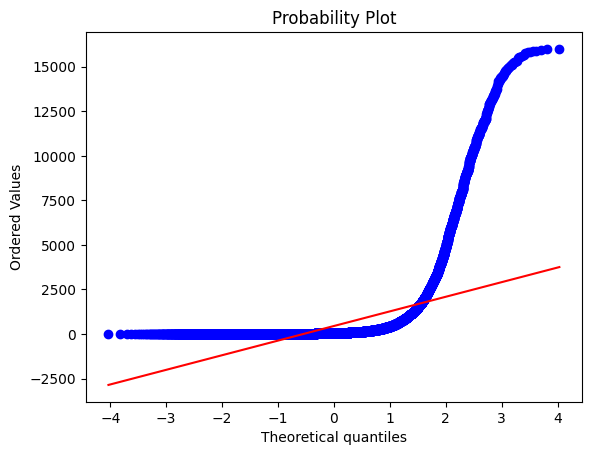

In [12]:
st.probplot(df_q99_filtered['total_buy'], plot=plt)

plt.show()

## Выводы

Данные распределены не нормально на уровне доверия 95%. При проверке гипотез будем использовать непараметрические тесты.

# Гипотезы

### Рассмотрим следующие гипотезы:
 1. Влияние заранее зарегистрировавшихся пользователей (задолго до первого логина/покупки) и пользователей, которые произвели покупку до регистрации
 2. Влияние браузера на прибыльность или на скорость покупки.
 3. Рассмотреть превалирирование определённого браузера/браузеров у юзеров, совершивших больше всего возвратов.
4. Аномальные всплески покупок/возвратов за весь период анализа.

Стратегия проверки: Формулируем каждую гипотезу в формате $H_0H_1$. В дальнейшем проверяем каждую гипотезу отдельно уровне доверия 95%.


### Гипотеза №1 "Консервы"
_Влияние заранее зарегистрировавшихся пользователей и пользователей, которые произвели покупку до регистрации_   

На выдвижение данной гипотезы меня натолкнула идея построения графиков зависимостей всех трёх дат (регистрация, первый логин, первая покупка) попарно, в поисках аномалий.

### Переформулируем гипотезу в формате H₀H₁:

H₀: У пользователей, заранее зарегистрировавшихся задолго до первого логина/покупки или совершивших покупку до регистрации, нет значимого отличия по среднему значению и дисперсиям по ключевым метрикам (количество покупок/возвратов, вероятность совершения покупки и т.д.) от пользователей с нормальной последовательностью событий (регистрация → логин → покупка).

H₁: У пользователей, заранее зарегистрировавшихся задолго до первого логина/покупки или совершивших покупку до регистрации, есть значимое отличие по среднему значению и дисперсиям по ключевым метрикам от пользователей с нормальной последовательностью событий.

In [13]:
# обогащу таблицу разницей времени между тремя событиями
df_enriched = df_zcore_filtered.copy()

df_enriched["first_buy_reg_diff"] = (
    df_zcore_filtered["first_buy"] - df_zcore_filtered["reg_dt"]
).dt.days
df_enriched["first_login_buy_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["first_buy"]
).dt.days
df_enriched["first_login_reg_diff"] = (
    df_zcore_filtered["first_login"] - df_zcore_filtered["reg_dt"]
).dt.days
display(df_enriched.head(2))


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return,first_buy_reg_diff,first_login_buy_diff,first_login_reg_diff
user_id,,,,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0,217,0,217
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0,5,-15,-10


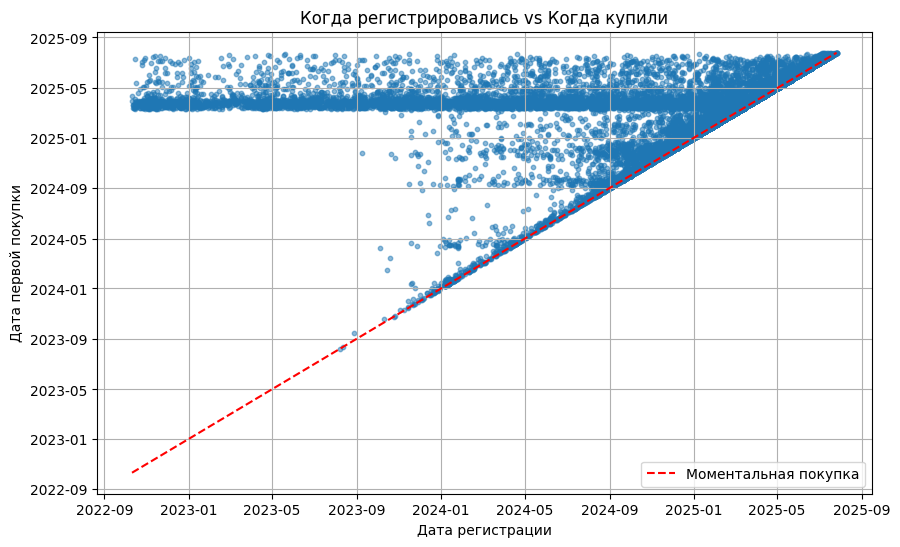

In [14]:
# Строим график зависимости дат регистрации и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда купили")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Видим аномальные отклонения от предсказуемой красной линии, есть объёмная группа юзеров, что регестрировались на протяжении всего периода, но покупки совершали в марте-апреле 2025. Это требует дополнительных исследований.

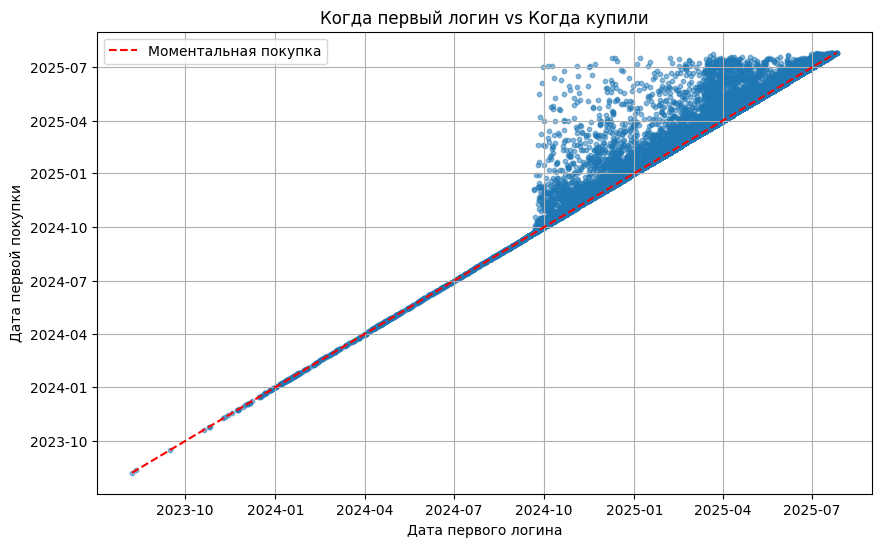

In [15]:
# Строим график зависимости дат первого логина и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда первый логин vs Когда купили")
plt.xlabel("Дата первого логина")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Тут, предварительно, не выводится надёжной визуальной зависимости.

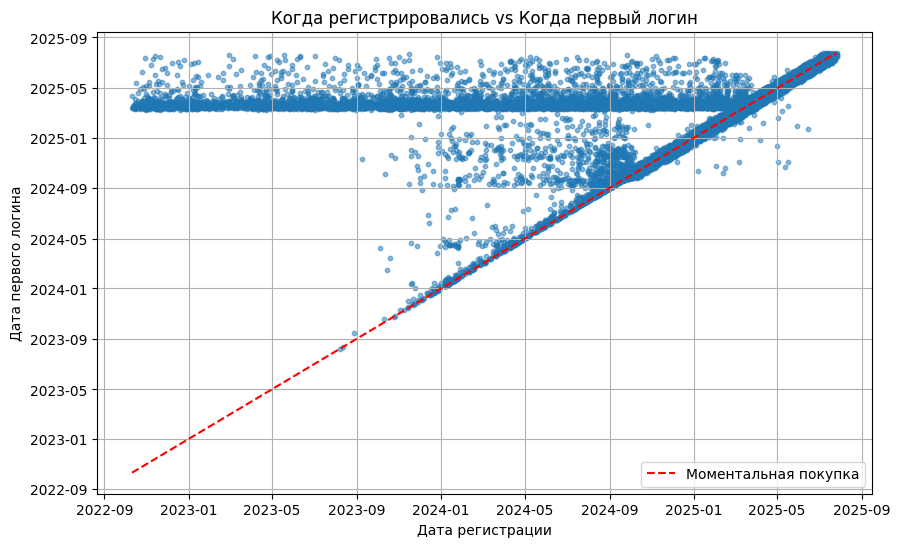

In [16]:
# Строим график зависимости дат регистрации и дат первого логина
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда первый логин")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первого логина")
plt.legend()
plt.grid(True)
plt.show()


Видим аномалию, аналогичную первому графику, соответственно регистрация была давно, а первая покупка и логин (если это одни и те же пользователи) произведены в марте-апреле 2025.   
Также заметен дополнительный аномальный интервал к концу 2024 года, также требующий анализа.

### Гипотеза №2 "Влияние браузера на прибыльность или на скорость покупки"

#### 2.1. Влияние браузера на прибыльность. Переформулируем гипотезу в формате H₀H₁:
H₀: Прибыль не зависит от типа браузера.

H₁: Прибыль зависит от типа браузера.

Рассмотрим распределение по прибыли:

Шапиро
Данные profit скорее всего распределены не нормально



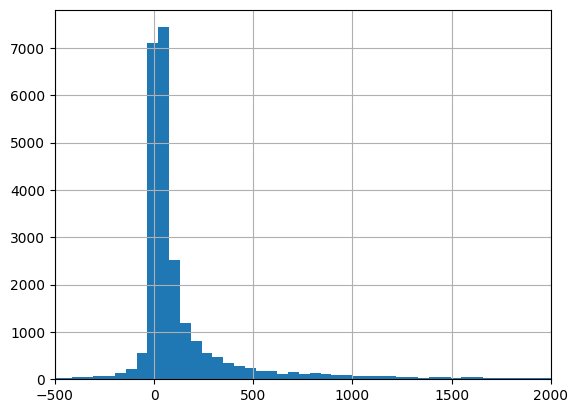

In [17]:
df_enriched['profit'] = df_enriched['total_buy'] - df_enriched['total_return']
ax = df_enriched['profit'].hist(bins=500)
ax.set_xlim(-500, 2000)
shapiro_check(df_enriched, 'profit')

Тест Шапиро-Уилка показывает, что данные распределены не нормально.
Прибыль — количественный показатель, групп по браузерам будет более 3-х, данные в них независимы и распределены не нормально, значит для проверки гипотезы используем критерий Краскела-Уоллиса:

In [18]:
groups = [
    df_enriched[df_enriched['browser'] == b]["profit"]
    for b in df_enriched['browser'].unique()
]

stat, p = st.kruskal(*groups)
print(stat, p)


492.93201281479514 3.393513416946111e-85


__p-value очень маленький (p ≪ 0.05), критерий Краскела-Уоллиса показывает уверенное влияние браузера на прибыльность каждого пользователя__

#### 2.2. Влияние браузера на скорость покупки. Переформулируем гипотезу в формате H₀H₁:
H₀: Скорость покупки не зависит от браузера.

H₁: Покупки зависит от браузера.

Рассмотрим распределение скорости покупки:


Шапиро
Данные first_buy_reg_diff скорее всего распределены не нормально



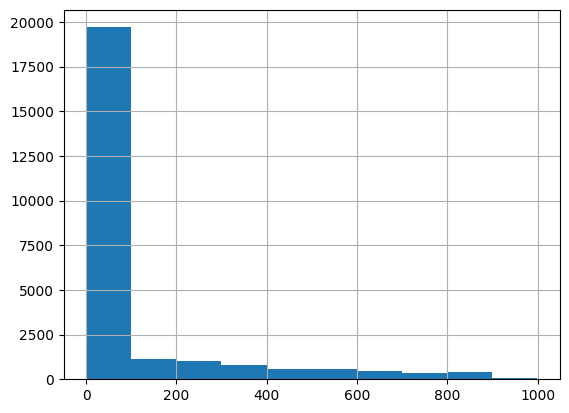

In [19]:
ax = df_enriched['first_buy_reg_diff'].hist(bins=10)
shapiro_check(df_enriched, 'first_buy_reg_diff')

Данные распределены не нормально, аналогично предыдущему пункту используем критерий Краскела-Уоллиса:

In [20]:
groups = [
    df_enriched[df_enriched.browser == b]["first_buy_reg_diff"]
    for b in df_enriched.browser.unique()
]

stat, p = st.kruskal(*groups)
print(stat, p)

327.32068248771145 1.0389295487805275e-51


__p-value очень маленький (p ≪ 0.05), критерий Краскела-Уоллиса показывает уверенное влияние браузера на скорость покупки каждого пользователя__

### Гипотеза №3 "Браузерные войны!"
_Предпочтения браузера у юзеров, совершивших больше всего покупок/возвратов._

Рассмотрим корреляцию используемых браузеров юзерами.

### Переформулируем гипотезу в формате $H_0H_1$:

$H_0$: Количество покупок имеет идентичные медианы по браузерам.

$H_1$: Количество покупок имеет различные медианы по браузерам.

Выбор критерия

**Шаг 1**: Какой тип переменной сравниваем?
- Количественная (числовая)

**Шаг 2**: Сколько групп сравнивается?
- \>2 групп.

**Шаг 3**: Группы зависимы или независимы?
- Независимые группы: сравниваются разные пользователи в одно и то же время.

**Шаг 4**: Есть ли нормальность распределения?

Для количественных переменных проверяем нормальность (например, с помощью теста Шапиро-Уилка или визуально).

**Шаг 5**: Выбор критерия

Критерий Краскела-Уоллиса

In [129]:
def statistic(args):
    h_statistic, p_value = st.kruskal(*args)
    
    result = "На уровне значимости 0.05 "
    if p_value < 0.05:
        result += "нулевая гипотеза отвергается. Есть значимые различия между группами."
    else:
        result += "нулевая гипотеза НЕ отвергается. Нет значимых различий между группами."
    return result

# Группировка первых покупок по браузерам и дням
df_enriched_3 = df_q99_filtered.copy()

df_enriched_3 = df_enriched_3.groupby(['first_buy',"browser" ]).agg(purchaise_count=('total_buy', 'count'))

df_enriched_3 = df_enriched_3.reset_index()
display(df_enriched_3.head())
shapiro_check(df_enriched_3, 'purchaise_count')
kstest_check(df_enriched_3, 'purchaise_count')

def df_browsers_array(dataset):
    result = []
    for browser_n in dataset["browser"].unique():
        df_browsers_n = dataset.loc[dataset["browser"] == browser_n]
        df_browsers_n = df_browsers_n.reset_index(drop=True)
        if len(df_browsers_n["browser"].unique()) > 1:
            shapiro_check(df_browsers_n, 'purchaise_count', n=None)
            kstest_check(df_browsers, 'purchaise_count')
        result.append(df_browsers_n['purchaise_count'].values)
    return result

statistic(df_browsers_array(df_enriched_3))

,first_buy,browser,purchaise_count
0,2023-08-08,2,1
1,2023-08-12,3,1
2,2023-09-16,1,1
3,2023-10-20,4,1
4,2023-10-25,1,1


Шапиро
Данные purchaise_count скорее всего распределены не нормально

Колмогоров-Смирнов
Данные purchaise_count скорее всего распределены не нормально



'На уровне значимости 0.05 нулевая гипотеза отвергается. Есть значимые различия между группами.'

## Гипотеза №3.1
_Среднее количество покупок на популярных браузерах отличается от неполулярных._

# Переформулируем гипотезу в формате $H_0H_1$:

$H_0$: Среднее количество покупок на N популярных браузерах статистически значимо НЕ отличается от кол-ва покупок на остальных.

$H_1$: Среднее количество покупок на N популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.

Выбор критерия

**Шаг 1**: Какой тип переменной сравниваем?
- Количественная (числовая)

**Шаг 2**: Сколько групп сравнивается?
- 2 группы.

**Шаг 3**: Группы зависимы или независимы?
- Независимые группы: сравниваются разные пользователи в одно и то же время.

**Шаг 4**: Есть ли нормальность распределения?
Нет

**Шаг 5**: Выбор критерия
U-критерий Манна — Уитни

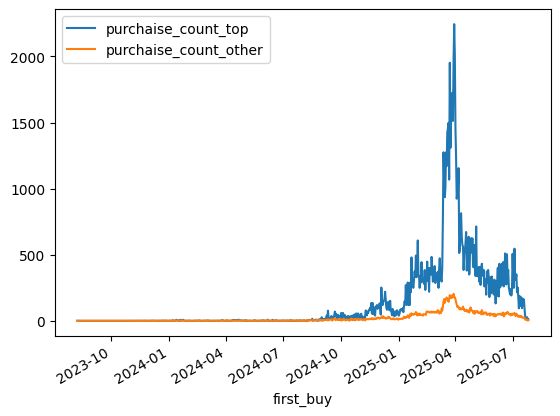

На уровне значимости 0.05 отвергается нулевая гипотеза. Среднее количество покупок на 1 популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.


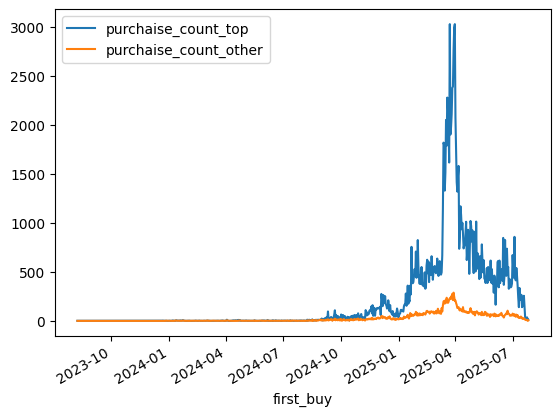

На уровне значимости 0.05 отвергается нулевая гипотеза. Среднее количество покупок на 2 популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.


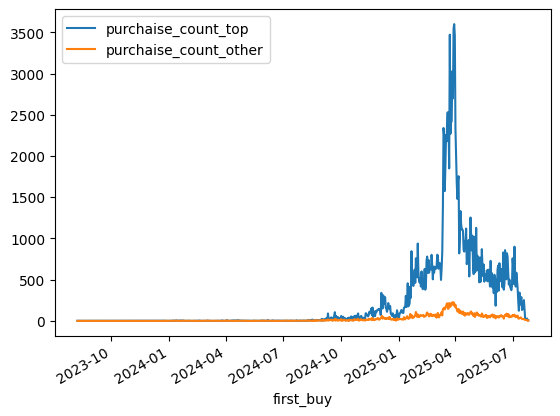

На уровне значимости 0.05 отвергается нулевая гипотеза. Среднее количество покупок на 3 популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.


In [127]:
def mannwhitneyu_statistic(args):
    h_statistic, p_value = st.mannwhitneyu(*args)

    result = "На уровне значимости 0.05 "
    if p_value < 0.05:
        result += f"отвергается нулевая гипотеза. Среднее количество покупок на {N} популярных браузерах статистически значимо отличается от кол-ва покупок на остальных."
    else:
        result += f"принимается нулевая гипотеза. Среднее количество покупок на {N} популярных браузерах статистически значимо НЕ отличается от кол-ва покупок на остальных."
    return result
    
for N in [1,2,3]:
    df_enriched_3_1 = df_enriched_3.copy()
    top_browsers = df_enriched_3_1[["browser", "purchaise_count"]].groupby("browser").sum().nlargest(n=N, columns="purchaise_count", keep='last').index.values
    df_top_browsers = df_enriched_3_1[df_enriched_3_1["browser"].isin(top_browsers)][["first_buy", "purchaise_count"]]
    df_other_browsers = df_enriched_3_1[~df_enriched_3_1["browser"].isin(top_browsers)][["first_buy", "purchaise_count"]]
    
    df_enriched_3_1 = df_top_browsers.merge(df_other_browsers, how='outer', on="first_buy", suffixes=("_top","_other")).fillna(0).groupby("first_buy").sum()

    df_enriched_3_1.plot()
    plt.show()
    print(mannwhitneyu_statistic([df_enriched_3_1["purchaise_count_top"].values, df_enriched_3_1["purchaise_count_other"].values]))

### Гипотеза №4 "Дружно все покупаем!"/"Дружно все возвращаем!"
_Аномальные всплески покупок/возвратов за весь период анализа._  

На выдвижение данной гипотезы меня натолкнула идея построения графика покупок/возвратов (возьму их разницу) относительно даты первого логина.    
Этот график не покажет точные даты покупок, так как общая разность Покупки и Возврата каждого клиента будет приложена к дате его первого логина.   
Но может показать клиентов, кто внёс большой вклад, с привязкой к дате его привлечения (косвенно успешность рекламных компаний и т.д).   
Рассмотрю его в разрезе {Total buy - Total return} (Cost value или доходность) и {Total return / Total buy} (Return rate или процент возвратов).

In [ ]:
# Подготовка данных
df_enriched_4 = df_q99_filtered.copy()

# Обогащение данных
df_enriched_4["cost_value"] = df_enriched_4["total_buy"] - df_enriched_4["total_return"]
df_enriched_4["return_rate"] = df_enriched_4["total_return"] / df_enriched_4["total_buy"]
df_enriched_4["period"] = df_enriched_4["first_buy"].dt.to_period("W")

profit_series_1 = (
    df_enriched_4[df_enriched_4["cost_value"] > 0].groupby("period")["cost_value"].sum()
)
loss_series_1 = (
    df_enriched_4[df_enriched_4["cost_value"] < 0].groupby("period")["cost_value"].sum()
)

plot_data_1 = pd.DataFrame(
    {"Прибыльные": profit_series_1, "Убыточные": loss_series_1}
).fillna(0)

profit_series_2 = (
    df_enriched_4[df_enriched_4["return_rate"] < 0.3].groupby("period")["cost_value"].sum()
)
loss_series_2 = df_enriched_4[df_enriched_4["return_rate"] > 0.3].groupby("period")[
    "cost_value"
].sum().abs() * (-1)

plot_data_2 = pd.DataFrame(
    {"Прибыльные (RR < 0.3)": profit_series_2, "Убыточные (RR > 0.3)": loss_series_2}
).fillna(0)

# Визуализация (два сабплота)
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(15, 12)
)  # Увеличили высоту для двух графиков

# График 1
plot_data_1.plot(kind="bar", stacked=True, color=["green", "red"], width=0.9, ax=ax[0])
ax[0].set_title("Баланс прибыли и убытков (Total buy минус Total return)")
ax[0].set_ylabel("Сумма (Cost Value)")

# График 2
plot_data_2.plot(kind="bar", stacked=True, color=["green", "red"], width=0.9, ax=ax[1])
ax[1].set_title("Баланс прибыли и убытков (по Return Rate >30%)")
ax[1].set_ylabel("Сумма (Cost Value)")

# Общее оформление
for axis in ax:
    axis.axhline(0, color="black", linewidth=1)
    axis.grid(axis="y", linestyle="--", alpha=0.7)
    axis.legend(loc="upper left")
    axis.set_xlabel("Неделя первого логина")

plt.tight_layout()
plt.show()


По графику сверху видно, что присутствует аномальный период (конец февраля-середина апреля 2025г), с большим количеством прибыльных и убыточных клиентов.   
Разовьём на основании данного графика подгипотезы для дальнейшего исследования.   
В основном будем использовать доходность, а не процент возвратов для дальнейшего анализа.

### Гипотеза №4.1 "Более ценные клиенты"
_В аномальный период пришло либо больше людей, либо более ценные клиенты_  

### Сформируем гипотезу в формате H₀H₁:   
H₀: Медианная прибыль (cost_value) в аномальный период (весна 2025) не отличается от обычного времени. Различия случайны.

H₁: Медианная прибыль в аномальный период значимо отличается от обычного времени.

Построение нулевой и альтернативной гипотез.   
● Выбор уровня значимости:   _0,05_   
● Сбор данных для проверки гипотезы: _Разбиение датафрейма на две группы по дате первого логина (аномалия и обычное время). Сравнение значения "Покупки минус возвраты"_  
● Выбор статистического теста.   
● Проведение статистического теста, вычисление p-value.   
● Сравнение p-value c уровнем значимости и вывод, отклонить или не отклонить нулевую гипотезу.   

Алгоритм выбора критерия     
Шаг 1: Какой тип переменной сравниваем?    
● Количественная (числовая) 
  
Шаг 2: Сколько групп сравнивается?     
● 2 группы.

Шаг 3: Группы зависимы или независимы?   
● Независимые группы: сравниваются разные суммы в разное время время.

Шаг 4: Есть ли нормальность распределения?   
Для количественных переменных проверяем нормальность (например, с помощью теста Шапиро-Уилка или визуально).   
Визуально распределение выглядит не нормально, но проверим отдельно тестом Шапиро-Уилка.

Выбраный метод: **U-критерий Манна-Уитни.**

In [ ]:
# Подготовка данных
spike_start = pd.to_datetime("2025-02-24")
spike_end = pd.to_datetime("2025-04-13")
df_enriched_4["is_spike"] = df_enriched_4["first_login"].between(spike_start, spike_end)

# Смотрим, сколько людей попало в аномальный период
print(df_enriched_4["is_spike"].value_counts())

spike_percentage = df_enriched_4["is_spike"].mean() * 100
print(f"\n{spike_percentage:.1f}% всех клиентов попадают в данный аномальный период!")


In [ ]:
# Формирование выборок
group_spike = df_enriched_4[df_enriched_4["is_spike"]]["cost_value"]
group_regular = df_enriched_4[~df_enriched_4["is_spike"]]["cost_value"]

# Проверка нормальности (Шапиро-Уилк)
shapiro_test = st.shapiro(
    group_spike.sample(min(5000, len(group_spike)))
)  # учитывая warning по размеру выборки >5000 (около 9000), сделал семпл
print(f"Тест на нормальность (Shapiro): p-value = {shapiro_test.pvalue:.2f}")

# Тест Манна-Уитни
stat, p_value = st.mannwhitneyu(group_spike, group_regular, alternative="two-sided")

print(f"\nСредняя прибыль (Аномалия): {group_spike.mean():.2f}")
print(f"Средняя прибыль (Обычное):  {group_regular.mean():.2f}")
print(f"Статистика U: {stat}")
print(f"P-value: {p_value:.2f}")

# Вывод
alpha = 0.05
if p_value < alpha:
    print("ВЫВОД: Отклоняем H0. Различия статистически значимы.")
    print("Аномальный период принес клиентов с другой доходностью.")
else:
    print("ВЫВОД: Не можем отклонить H0. Доходность клиента не изменилась.")


### Гипотеза №4.2 "Токсичные" клиенты
_В аномальный период процент клиентов с отрицательной доходностью изменился_  

Построение нулевой и альтернативной гипотез.   
● Выбор уровня значимости:   _0,05_   
● Сбор данных для проверки гипотезы: _Период и тип клиента (аномальный/не аномальный; доходный/убыточный, если cost_value < 0)._  
● Выбор статистического теста.   
● Проведение статистического теста, вычисление p-value.   
● Сравнение p-value c уровнем значимости и вывод, отклонить или не отклонить нулевую гипотезу.   

### Сформируем гипотезу в формате H₀H₁:   
H₀: Доля убыточных клиентов в аномальный период не отличается от доли в обычное время. Зависимости нет.

H₁: Доля убыточных клиентов в аномальный период значимо отличается (выше или ниже) от обычного времени. Зависимость есть.

Алгоритм выбора критерия   
Шаг 1: Какой тип переменной сравниваем?   
● Качественная (категориальная)  
 
Шаг 2: Сколько групп сравнивается?   
● 2 группы.

Шаг 3: Группы зависимы или независимы?   
● Независимые группы: Один и тот же пользователь может совершить свой первый вход только один раз.   

Шаг 4: Есть ли нормальность распределения?   
Проверка на нормальность не требуется (данные категориальные)

Выбранный метод: **Критерий Хи-квадрат Пирсона**

In [ ]:
# Подготовка данных
df_enriched_4["is_toxic"] = df_enriched_4["cost_value"] < 0

# Таблица сопряженности
contingency_table = pd.crosstab(df_enriched_4["is_spike"], df_enriched_4["is_toxic"])
contingency_table.index = ["Обычное время", "Аномальный период"]
contingency_table.columns = ["Нормальные", "Убыточные"]
contingency_table.index.name = "Период"
contingency_table.columns.name = "Тип клиента"

print("Распределение клиентов (Убыточность = положительность или отрицательность Cost value):")
display(contingency_table)

# Расчет процентов (для понимания направления)
toxic_rates = df_enriched_4.groupby("is_spike")["is_toxic"].mean() * 100
print(f"Процент убыточных клиентов в обычное время: {toxic_rates[False]:.2f}%")
print(
    f"Процент убыточных клиентов во время аномального периода: {toxic_rates[True]:.2f}%"
)

# Тест Хи-квадрат
chi2, p_value, dof, expected = st.chi2_contingency(contingency_table)

print(f"\nСтатистика Chi2: {chi2:.2f}")
print(f"P-value: {p_value:.2f}")

# Вывод
alpha = 0.05
if p_value < alpha:
    print("ВЫВОД: Отклоняем H0. Различия статистически значимы.")
else:
    print(
        "ВЫВОД: Не можем отклонить H0. Различий нет (доля убыточных клиентов не изменилась)."
    )


In [ ]:
# Альтернативный вариант, для процентного соотношения возврата
df_enriched_4["is_toxic"] = df_enriched_4["return_rate"] > 0.3

# Таблица сопряженности
contingency_table = pd.crosstab(df_enriched_4["is_spike"], df_enriched_4["is_toxic"])
contingency_table.index = ["Обычное время", "Аномальный период"]
contingency_table.columns = ["Нормальные", "Убыточные"]
contingency_table.index.name = "Период"
contingency_table.columns.name = "Тип клиента"

print("Распределение клиентов (Убыточность = Return rate > 0.3):")
display(contingency_table)

# Расчет процентов (для понимания направления)
toxic_rates = df_enriched_4.groupby("is_spike")["is_toxic"].mean() * 100
print(f"Процент убыточных клиентов в обычное время: {toxic_rates[False]:.2f}%")
print(
    f"Процент убыточных клиентов во время аномального периода: {toxic_rates[True]:.2f}%"
)

# Тест Хи-квадрат
chi2, p_value, dof, expected = st.chi2_contingency(contingency_table)

print(f"\nСтатистика Chi2: {chi2:.2f}")
print(f"P-value: {p_value:.2f}")

# Вывод
alpha = 0.05
if p_value < alpha:
    print("ВЫВОД: Отклоняем H0. Различия статистически значимы.")
else:
    print(
        "ВЫВОД: Не можем отклонить H0. Различий нет (доля убыточных клиентов не изменилась)."
    )

### Дополнительный анализ: Источник аномального всплеска
Чтобы понять природу всплеска активности весной 2025 года, проанализирую даты регистрации пользователей, покупавших в данный период.

In [ ]:
# Когда зарегистрировались люди из аномального периода
spike_users = df_enriched_4[df_enriched_4["is_spike"]]
median_reg_date = spike_users["reg_dt"].median()

print(
    f"Медианная дата регистрации пользователей из аномального периода: {median_reg_date}"
)

# Для сравнения: медиана регистрации в "обычное" время
regular_users = df_enriched_4[~df_enriched_4["is_spike"]]
print(f"Медианная дата регистрации в обычное время: {regular_users['reg_dt'].median()}")

# Визуализация
plt.figure(figsize=(10, 5))
plt.hist(
    spike_users["reg_dt"], bins=50, color="orange", alpha=0.5, label="Аномальный период"
)
plt.hist(
    regular_users["reg_dt"], bins=50, color="blue", alpha=0.3, label="Обычное время"
)
plt.title("Когда регистрировались пользователи из разных периодов?")
plt.xlabel("Дата регистрации")
plt.ylabel("Количество пользователей")
plt.legend()
plt.show()


По графику видно, что покупки совершали как и большое количество новых клиентов, так и "реактивировавшиеся" старые.    
Проведем анализ их количества, среднего дохода и процента возвратов с каждой из этих групп.

In [ ]:
spike_start = pd.to_datetime(
    "2025-02-01"  # отсечку "новых" клиентов поставлю на ~ три недели раньше начала аномального периода
)
spike_end = pd.to_datetime("2025-04-13")

spike_users_new = spike_users["reg_dt"].between(spike_start, spike_end)
spike_users_old = spike_users["reg_dt"] < spike_start

sum_new = spike_users[spike_users_new]["cost_value"].sum()
sum_old = spike_users[spike_users_old]["cost_value"].sum()

count_new = spike_users[spike_users_new]["cost_value"].count()
count_old = spike_users[spike_users_old]["cost_value"].count()

print(
    f"Количество новых клиентов из аномального периода: {count_new} \nКоличество старых клиентов из аномального периода: {count_old}\n"
)

# визуализация
labels = ["Старые клиенты \n(до 01.02.25)", "Новые клиенты \n(с 01.02.25)"]
sizes = [sum_old, sum_new]

plt.figure(figsize=(7, 7))

plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, explode=(0.05, 0))

plt.title("Распределение Cost Value по дате регистрации")
plt.show()


In [ ]:
# Фильтрация
old_stats = spike_users.loc[spike_users_old, "cost_value"]
new_stats = spike_users.loc[spike_users_new, "cost_value"]

mean_df = pd.DataFrame(
    {
        "Старые клиенты (до 01.02.25)": [old_stats.mean()],
        "Новые клиенты (с 01.02.25)": [new_stats.mean()],
    },
    index=["Среднее (Mean)"],
)


# Визуализация
mean_df.plot(kind="bar", figsize=(10, 6), width=0.7)
plt.title(
    "Кто выгоднее: Старые клиенты или Новые клиенты\n(Cost Value на одного человека)"
)
plt.ylabel("Cost Value")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Пользователи")
plt.show()

print(old_stats.mean())
print(new_stats.mean())


Посчитаем "кислотность" клиентов (Return_rate > 0.3) в обеих группах.

In [ ]:
# Подготовка данных
df_old = spike_users.loc[spike_users_old]
df_new = spike_users.loc[spike_users_new]

# Расчёты
pct_old = (df_old["return_rate"] > 0.3).mean() * 100
pct_new = (df_new["return_rate"] > 0.3).mean() * 100
count_old = (df_old["return_rate"] > 0.3).sum()
count_new = (df_new["return_rate"] > 0.3).sum()

# Визуализация
viz_df = pd.DataFrame(
    {"Старые": [pct_old], "Новые": [pct_new]},
    index=["Процент клиентов с большим отношением возвратов"],
)

ax = viz_df.plot(kind="bar", figsize=(8, 6), rot=0)

plt.title("Доля клиентов с Return Rate > 0.3")
plt.ylabel("Процент от группы (%)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%", padding=3)

plt.show()
print(f"Старые клиенты возвращают товары чаще в {pct_old / pct_new:.1f} раз (с учётом выбранной отсечки Return rate).")


## Наблюдения:
На графиках кажется, что подавляющее большинство пользователей аномального периода (оранжевый цвет) зарегистрировались в феврале-марте 2025 года.   
Но с учётом дополнительного анализа можно утверждать, что произошла "реактивация" значительного количества старых пользователей и эти группы примерно равны:   
- Количество новых клиентов из аномального периода: 5116 
- Количество старых клиентов из аномального периода: 4357   

Медианная дата регистрации — 25 февраля 2025 также косвенно на это указывает.   
При этом в денежном отношении старые пользователи выгодней, из-за средней большей прибыли на одного человека : 628 против 149.

## Вывод по гипотезам 4.1 и 4.2:
Аномалия вызвана и притоком новых пользователей, и "реактивацией" старых.   
Учитывая, что аномальная группа, в целом, показала более высокую чистую прибыль (см. Гипотеза 4.1) и соизмеримую токсичность (см. Гипотеза 4.2), можно утверждать, что каналы привлечения, использованные в начале 2025 года, привлекли наиболее качественную аудиторию за всю историю наблюдений и, в том числе, смогли "реактивировать" старых пользователей.

При этом у старых клиентов (ранняя дата регистрации и "реактивация" в момент "бума" покупок) - доля возвратов больше.   
Необходимо работать с этой группой с усложнением механизма возврата товаров, либо, при возможности, пренебречь этим, так как средний доход с такого клиента, с учётом возвратов, всё равно выше, чем от новых клиентов.
## Рекомендация:
Детально изучить источники трафика за февраль-март 2025, для анализа причин успешности каналов привлечения.